# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
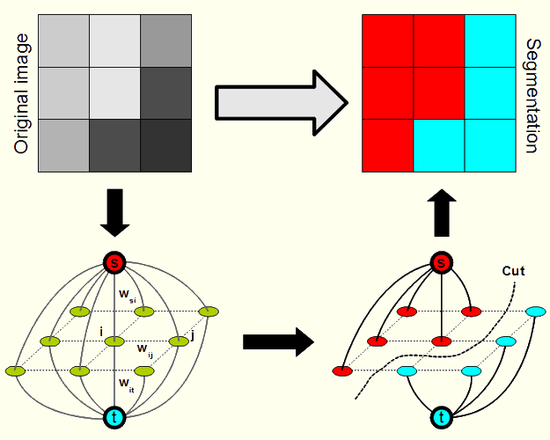

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

### GrabCut 
GrabCut is an image segmentation method based on **graph cuts**. Requires a **user-specified bounding box** around the object to be segmented.Estimates the color distribution of the target object and that of the  background using a **Gaussian Mixture Model**.Then it performs graph cuts to divide pixels into background and foreground.This two-step procedure is repeated until **convergence**.

In [1]:
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from random import randint
import igraph as ig


BG = 0 # Background
FG = 1 # Foreground
EXP_BG = 2 # Expected background
EXP_FG = 3 # Expected foreground

**Beta smoothing** : 
First find the left_difference, right_difference, diagonal_difference arrays.Finds beta according to the formula mentioned in the paper.Find the smoothing parameter arrays based on the formulae in the the paper corresponding to the 4-neighbourhodd positions.

In [2]:
def calculateBinaryPotential(q, p, beta,gamma,diag=False):
    potential = beta * np.sum((p - q) * (p - q), axis=2)
    potential = gamma * np.exp(-potential)
    if diag: potential = potential / np.sqrt(2) 
    return potential.flatten()


def smoothingTermV(img, gamma):
    rows, cols,_ = img.shape
    left = img[:, 1:]
    right = img[:, :-1]
    top = img[1:, :] 
    bottom = img[:-1, :]
    lefttop = img[1:, 1:] 
    rightbottom = img[:-1, :-1]
    righttop = img[1:, :-1] 
    leftbottom = img[:-1, 1:]
    ssum = np.sum(np.sum((left - right)**2)) + np.sum(np.sum((top-bottom)**2)) + \
            np.sum(np.sum((lefttop-rightbottom)**2)) + np.sum(np.sum((leftbottom-righttop)**2))  
    beta = 1 / (2 * ssum / (4*cols*rows - 3*cols - 3*rows + 2))
    weight = calculateBinaryPotential(left,right,beta,gamma)
    weight = np.hstack((weight,calculateBinaryPotential(top,bottom,beta,gamma)))
    weight = np.hstack((weight,calculateBinaryPotential(lefttop,rightbottom,beta,gamma,True)))
    weight = np.hstack((weight,calculateBinaryPotential(leftbottom,righttop,beta,gamma,True)))
    tem = np.array([i for i in range(rows*cols)])
    idx = tem.reshape(rows, cols)
#     return weight.tolist(),edges
    hor1 = idx[:, 1:].flatten()
    hor2 = idx[:, :-1].flatten()
#     print(hor1.shape)
    hor = np.array([hor1,hor2]).T
    #up_neighbourhood
    ver1 = idx[1:, :].flatten()
    ver2 = idx[:-1, :].flatten()
    ver = np.array([ver1,ver2]).T
    #upleft_neighbourhood
    diag11 = idx[1:, 1:].flatten()
    diag12 = idx[:-1, :-1].flatten()
    diag1 = np.array([diag11,diag12]).T
    #upright_neighbourhood
    diag21 = idx[1:, 1:].flatten()
    diag22 = idx[:-1, :-1].flatten()
    diag2 = np.array([diag21,diag22]).T
    edges = np.vstack((hor,ver,diag1,diag2))
    
    return weight,edges

**construct_graph** : 
* Constructs the graph for performing mincut by building edges and graph edge capacities.
* The graph has 2 type of edges
    - To represent the likelihood of a pixel belonging to either the foreground or background.
    - To enforce the smoothness constraints. These edges are put between all pairs of adjacent pixels.
* we create edges with source and sink and calculate corresponding weights as follows :
    - If they are probably background or foreground then we calculate their weight using negative log likelihood
    this comes inbuilt in sklearn's gaussianMixture object as score samples.
    -If the are background then their weight with sink is infinity and source is zero and vice-versa
* Finally, uses the igraph moule to build a graph object

In [3]:
def calc_edges_weights(img, bgd_gmm,Vweights,Vedges, fgd_gmm, mask, s, t, gamma):
    rows, cols = img[:, :, 2].shape

#     weight,edgesbin = smoothingTermV(img, gamma)
    # t-links
    
    ## pr_indices
    prob_idx = np.where(np.logical_or(mask.reshape(-1) == EXP_BG, mask.reshape(-1) == EXP_FG))
    back_idx = np.where(mask.reshape(-1) == BG)
    fore_idx = np.where(mask.reshape(-1) == FG)
    
    edg = Vedges
    
    s1 = np.ones(prob_idx[0].size) * s
    sedg = np.array([s1,prob_idx[0]]).T
    edg = np.vstack((edg,sedg))
    
    t1 = np.ones(prob_idx[0].size) * t
    tedg = np.array([t1,prob_idx[0]]).T
    edg = np.vstack((edg,tedg))
    
    s1 = np.ones(back_idx[0].size) * s
    sedg = np.array([s1,back_idx[0]]).T
    edg = np.vstack((edg,sedg))
    
    t1 = np.ones(back_idx[0].size) * t
    tedg = np.array([t1,back_idx[0]]).T
    edg = np.vstack((edg,tedg))
    
    s1 = np.ones(fore_idx[0].size) * s
    sedg = np.array([s1,fore_idx[0]]).T
    edg = np.vstack((edg,sedg))
    
    t1 = np.ones(fore_idx[0].size) * t
    tedg = np.array([t1,fore_idx[0]]).T
    edg = np.vstack((edg,tedg))
    
    edges = [(int(x),int(y)) for x,y in edg]

    weights = Vweights
    weights = np.hstack((weights,-bgd_gmm.score_samples(img.reshape(-1, 3)[prob_idx])))
    weights = np.hstack((weights,-fgd_gmm.score_samples(img.reshape(-1, 3)[prob_idx])))
    weights = np.hstack((weights,np.zeros(back_idx[0].size)))
    weights = np.hstack((weights,np.ones(back_idx[0].size) * 9 * gamma))
    weights = np.hstack((weights,np.zeros(fore_idx[0].size)))
    weights = np.hstack((weights,np.ones(fore_idx[0].size) * 9 * gamma))
    weights = weights.tolist()
#     weights.extend(weight)
#     edges.extend(edgesbin)
    
    return edges, weights

In [4]:
def grabcut(img, mask, bbox, gmm_comps=5, num_iters=3):
    print("GrabCut algorithm has started...")
    rows, cols = img.shape[0],img.shape[1]
    tem = np.array([i for i in range(rows*cols)])
    idx = tem.reshape(rows, cols)
    s = cols * rows
    t = s + 1
    img = img.astype(np.float64)
    gamma = 50 
    if np.count_nonzero(mask) == 0:
        mask[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]] = 3
    bgd_gmm = GaussianMixture(n_components = gmm_comps, covariance_type='full')
    fgd_gmm = GaussianMixture(n_components = gmm_comps, covariance_type='full')
    Vedges,Vweights = smoothingTermV(img,gamma)
    
    for num in range(num_iters):       
        ## FG/BG gmm fit
        print("iteration number " + str(num))
#         fore_idx, back_idx = classify_pixels(mask)
        back_idx = np.where(np.logical_or(mask == 0, mask == 2))
        fore_idx = np.where(np.logical_or(mask == 1, mask == 3))
        bgd_gmm.fit(img[back_idx])
        fgd_gmm.fit(img[fore_idx])
        ## FG/BG gmm_predict
        edges, weights = calc_edges_weights(img,bgd_gmm,Vedges,Vweights, fgd_gmm, mask, s, t, gamma)
        graph = ig.Graph(2 + cols * rows)
        graph.add_edges(edges)
        pr_indexes = np.where(np.logical_or(mask == 2, mask == 3))
        mincut = graph.st_mincut(s, t, weights)
        mask[pr_indexes] = np.where(np.isin(idx[pr_indexes], mincut.partition[0]),3, 2)
        

    mask2 = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')
    
    print("done")
    return mask2,mask

In [5]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                self.FLAGS['rect_or_mask'] = 1
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [6]:
def run(filename: str):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 2}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 3}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
    updatedmask = None                               #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)

        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            print("Draw background strokes...")
            FLAGS['value'] = DRAW_BG
            if FLAGS['rect_or_mask'] <= 0: continue
            print("Algorithm has started")
            idx = np.where(mask == 2)
            updatedmask[idx] = 0
            mask2,updatedmask = grabcut(img, updatedmask, rect, num_iters = 2, gmm_comps = 3)
            FLAGS['rect_or_mask'] = 0
            output = cv2.bitwise_and(img2, img2, mask = mask2)
#             cv2.imshow('Segmented output', updatedmask)
        
        elif k == ord('1'):
            print("Draw foreground strokes...")
            FLAGS['value'] = DRAW_FG
            if FLAGS['rect_or_mask'] <= 0: continue
            print("Algorithm has started")
            idx = np.where(mask == 3)
            updatedmask[idx] = 1
            mask2,updatedmask = grabcut(img, updatedmask, rect, num_iters = 2, gmm_comps = 3)
            FLAGS['rect_or_mask'] = 0
            output = cv2.bitwise_and(img2, img2, mask = mask2)
            
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            rect = list(FLAGS['RECT'])
            print("Selected Rectangle=",rect)
#             print("start")
#             rect = [70, 31, 538, 427]
            mask2,updatedmask = grabcut(img, mask, rect, num_iters = 3, gmm_comps = 3)
            EventObj.flags = FLAGS
            output = cv2.bitwise_and(img2, img2, mask = mask2)
#             plt.imshow(output)

In [8]:
if __name__ == '__main__':
    filename = '../images/banana2.jpg'               # Path to image file
    run(filename)
    cv2.destroyAllWindows()

Selected Rectangle= [18, 119, 580, 335]
GrabCut algorithm has started...
iteration number 0
iteration number 1
iteration number 2
done
Draw background strokes...
Draw background strokes...
Algorithm has started
GrabCut algorithm has started...
iteration number 0
iteration number 1
done
Draw background strokes...
Draw background strokes...
Algorithm has started
GrabCut algorithm has started...
iteration number 0
iteration number 1
done
Draw background strokes...


In [112]:
cv2.destroyAllWindows()

In [76]:
def dynamic_plotting(images, rows, cols, title=None):
    plt.figure(figsize=(20, 25))
    idx=0
    for i in range(1, rows+1):
        for j in range(1, cols+1):
            img = images[idx]
            plt.subplot(rows, cols, idx+1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(title[idx])
            idx+=1
            plt.axis('off')
    plt.show()

## working of stroke

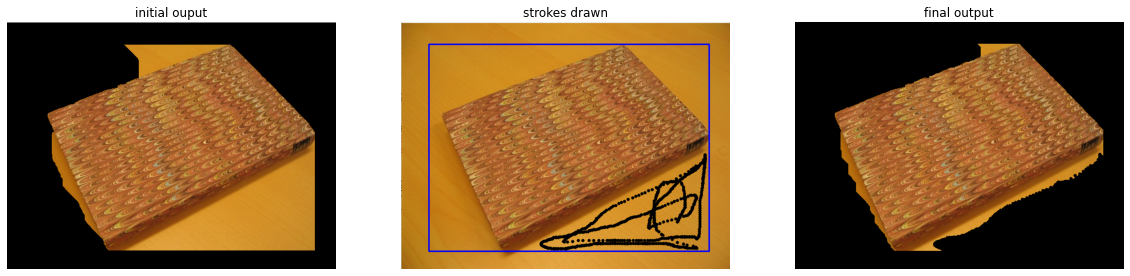

In [77]:
# print(len(comps))
strokes = []
for i in range(1,4):
    im = cv2.imread("./ouputs/stroke" + str(i) + ".png")
    strokes.append(im)
titles = ["initial ouput","strokes drawn","final output"]
dynamic_plotting(strokes,1,3,titles)

## Changes in no of iterations


In [ ]:
img = cv2.imread("../images/banana3.jpg")

images = [img]
for i in range(1,6):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    rect=[25, 55,575,390]
    mask2,_ = grabcut(img, mask, rect, num_iters = i, gmm_comps = 3)
    output = cv2.bitwise_and(img, img, mask=mask2)
    images.append(output)
plt.imshow(images[1])

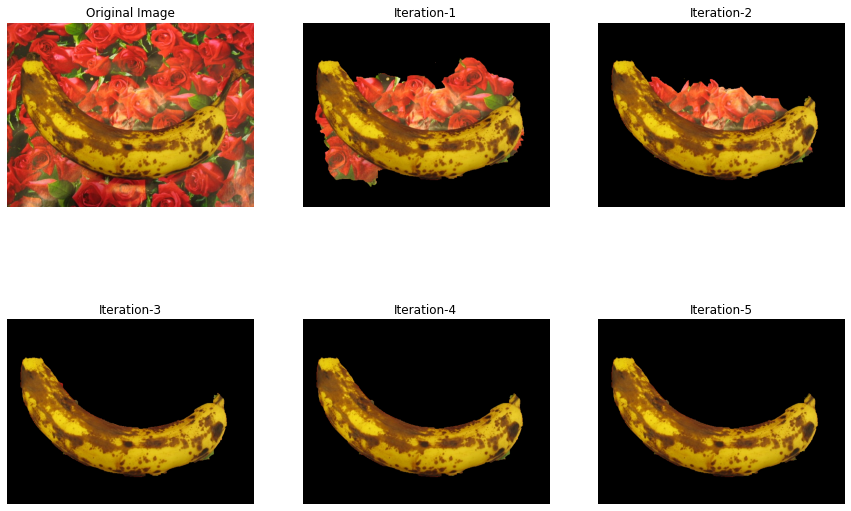

In [51]:
titles = ["Original Image", "Iteration-1", "Iteration-2", "Iteration-3"
         , "Iteration-4", "Iteration-5"]
dynamic_plotting(images,2,3,titles)

In [ ]:
img = cv2.imread("../images/elefant.jpg")

images = [img]
for i in range(1,6):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    rect=[61, 35, 472, 419]
    mask2,_ = grabcut(img, mask, rect, num_iters = i, gmm_comps = 3)
    output = cv2.bitwise_and(img, img, mask=mask2)
    images.append(output)


plt.imshow(images[1])

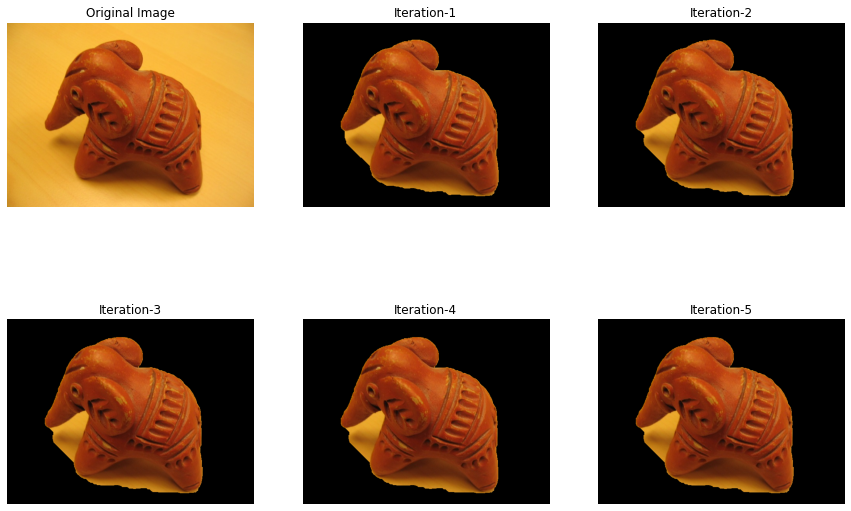

In [26]:
titles = ["Original Image", "Iteration-1", "Iteration-2", "Iteration-3"
         , "Iteration-4", "Iteration-5"]
dynamic_plotting(images,2,3,titles)

## Changing gamma values 10,50,100

In [ ]:
imgb = cv2.imread("../images/banana3.jpg")
imge = cv2.imread("../images/elefant.jpg")
imgk = cv2.imread("../images/book.jpg")
bookrect = [70, 31, 538, 427]
bananarect = [25, 55,575,390]
elefantrect = [61, 35, 472, 419]
images = [imgb,imge,imgk]
rects = [bookrect,bananarect,elefantrect]
gamma10 = []
for img,rect in zip(images,rects):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask2,_ = grabcut(img, mask, rect, num_iters = 3, gmm_comps = 3)
    output = cv2.bitwise_and(img, img, mask=mask2)
    gamma10.append(output)

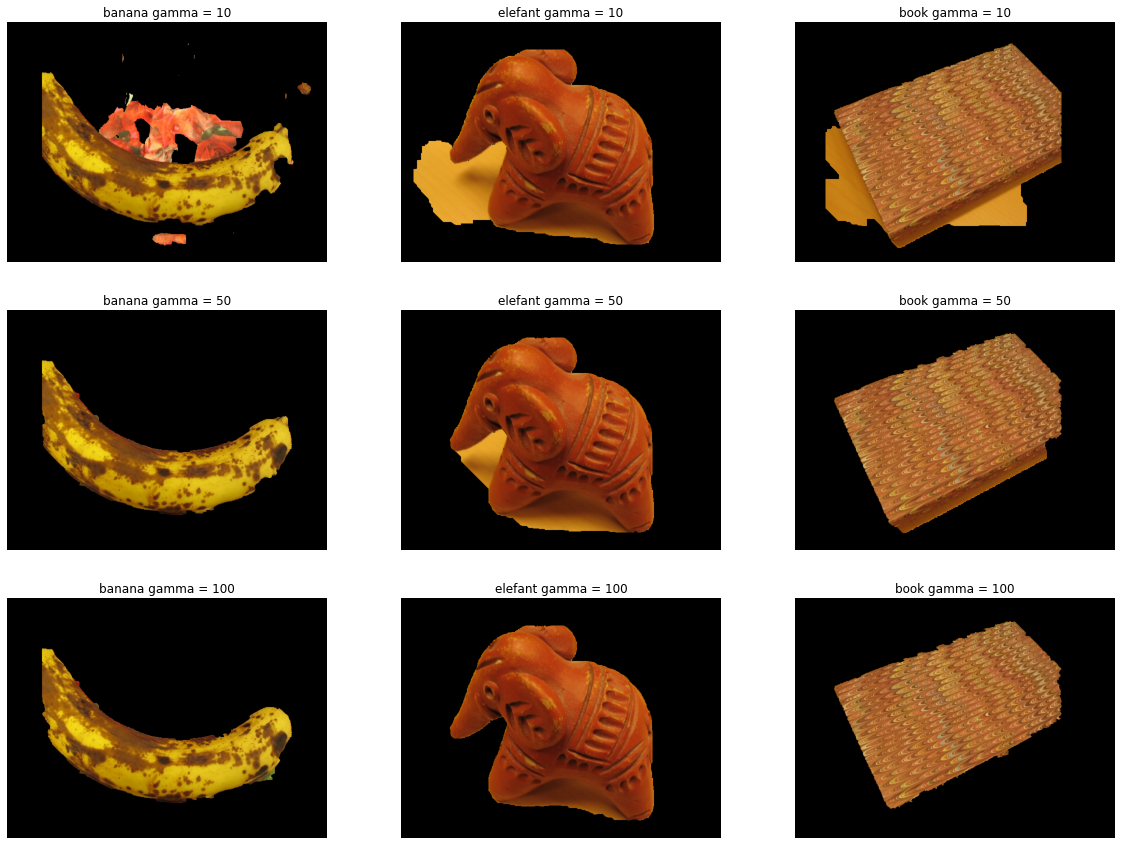

In [87]:
titles = ["banana gamma = 10","elefant gamma = 10","book gamma = 10",
          "banana gamma = 50","elefant gamma = 50","book gamma = 50",
         "banana gamma = 100","elefant gamma = 100","book gamma = 100"]
dynamic_plotting(gamma10 + gamma500 + gamma100,3,3,titles)
# for i,img in enumerate(gamma10):
#     cv2.imwrite("gamma/gamma10_" + str(i) + ".jpg",img)

In [ ]:
imgb = cv2.imread("../images/banana3.jpg")
imge = cv2.imread("../images/elefant.jpg")
imgk = cv2.imread("../images/book.jpg")
bookrect = [70, 31, 538, 427]
bananarect = [25, 55,575,390]
elefantrect = [61, 35, 472, 419]
images = [imgb,imge,imgk]
rects = [bookrect,bananarect,elefantrect]
comps = []

for i in range(1,10,2):
    for img,rect in zip(images,rects):
#         print(i)
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        mask2,_ = grabcut(img, mask, rect, num_iters = 3, gmm_comps = i)
        output = cv2.bitwise_and(img, img, mask=mask2)
        comps.append(output)

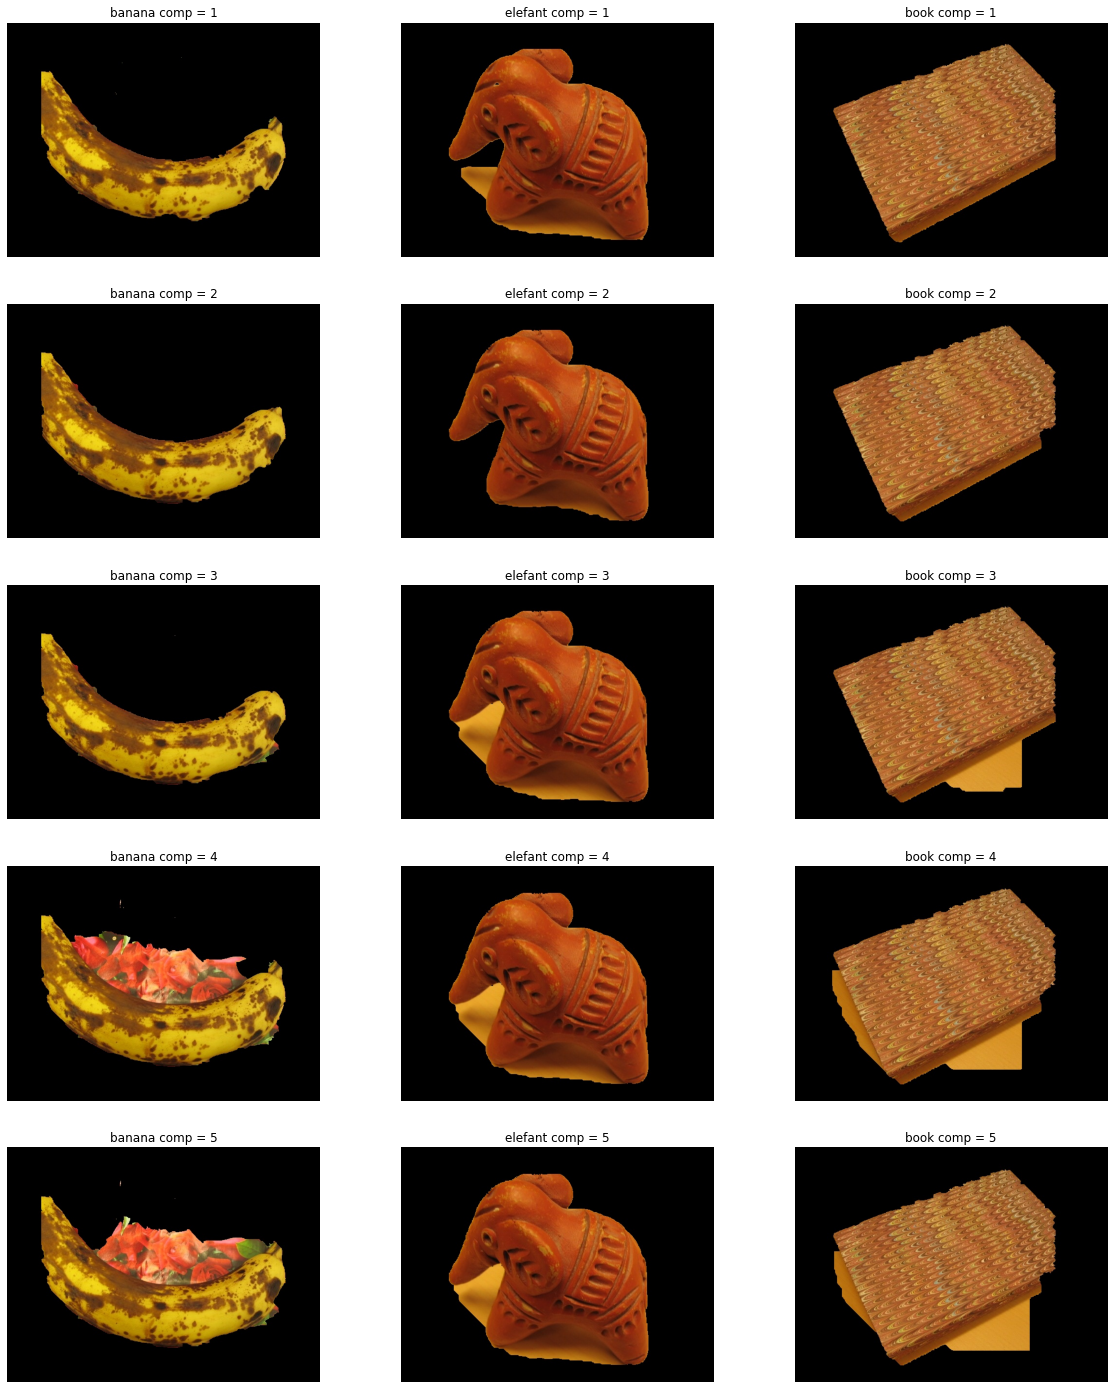

In [59]:
# print(len(comps))
comps = []
for i in range(15):
    im = cv2.imread("./ouputs/comp" + str(i) + ".jpg")
    comps.append(im)
titles = ["banana comp = 1","elefant comp = 1","book comp = 1",
         "banana comp = 2","elefant comp = 2","book comp = 2",
         "banana comp = 3","elefant comp = 3","book comp = 3",
         "banana comp = 4","elefant comp = 4","book comp = 4",
         "banana comp = 5","elefant comp = 5","book comp = 5"]
dynamic_plotting(comps,5,3,titles)

## Random outputs

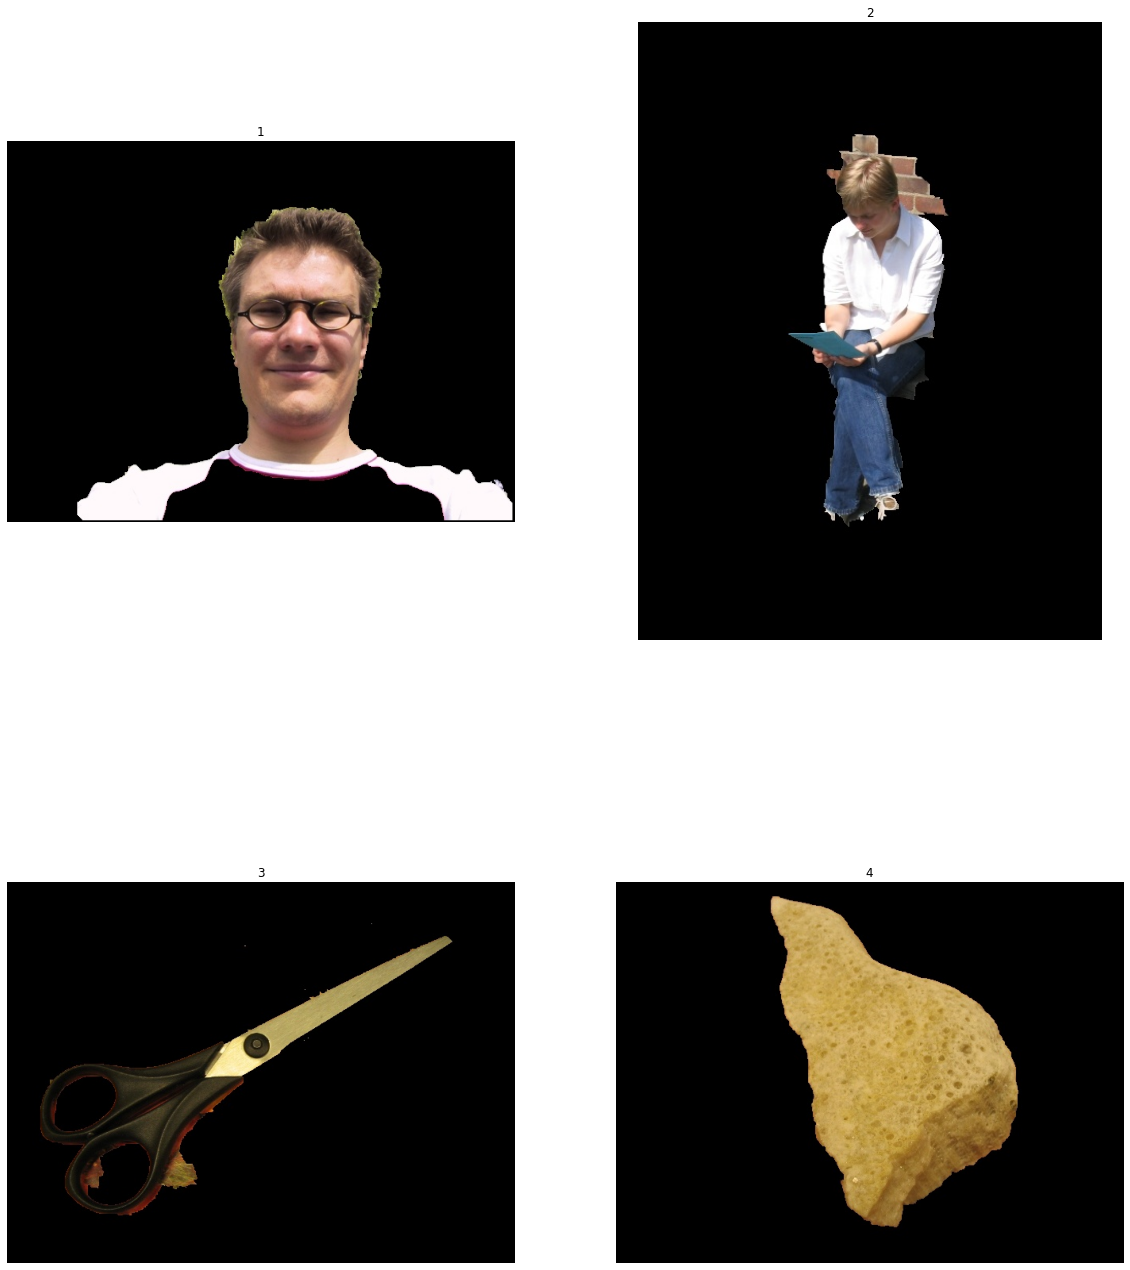

In [118]:
# plt.imshow(output)
# cv2.imwrite("./ouputs/person1out.jpg" , output)
# im = cv2.imread("./ouputs/comp" + str(i) + ".jpg")
images = []
titles = ["1","2","3","4"]
for i in range(1,5):
    im = cv2.imread("./ouputs/out" + str(i) + ".jpg")
    images.append(im)
    
dynamic_plotting(images,2,2,titles)
    